In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
from earthkit.climate import shapes

In [2]:
dataset = xr.open_dataset(
    "test_data/era5_temperature_europe_2015.grib", chunks={'time': 48}
)
dataarray = dataset.t2m
geodataframe = gpd.read_file(
    "test_data/nuts/NUTS_RG_60M_2021_4326_LEVL_0.geojson"
)

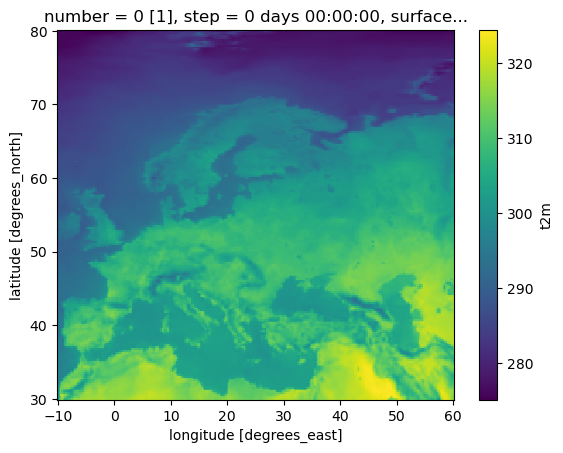

In [3]:
dataarray.max(dim='time').plot()

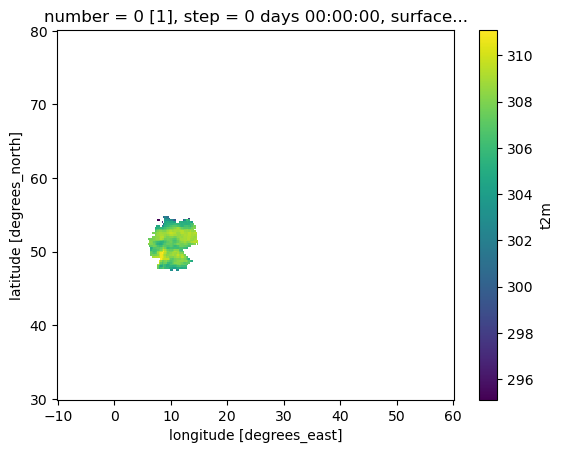

In [4]:
masked_data = shapes.masks(dataarray, geodataframe)
masked_data.sel(FID='DE').max(dim='time').plot()

In [7]:
reduced_data = shapes.reduce(dataarray, geodataframe, how=np.nanmax)
reduced_data

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,0
0,DK,DK,0.0,DK,Danmark,Danmark,0.0,0.0,0.0,DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54...",NaN
1,RS,RS,0.0,RS,Serbia,Srbija/Сpбија,0.0,0.0,0.0,RS,"POLYGON ((21.47920 45.19300, 21.35850 44.82160...",NaN
2,EE,EE,0.0,EE,Eesti,Eesti,0.0,0.0,0.0,EE,"MULTIPOLYGON (((27.35700 58.78710, 27.64490 57...",NaN
3,EL,EL,0.0,EL,Elláda,Ελλάδα,0.0,0.0,0.0,EL,"MULTIPOLYGON (((28.07770 36.11820, 27.86060 35...",NaN
4,ES,ES,0.0,ES,España,España,0.0,0.0,0.0,ES,"MULTIPOLYGON (((4.39100 39.86170, 4.19070 39.7...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"[<xarray.DataArray 't2m' ()>\narray(272.28174,..."
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"[<xarray.DataArray 't2m' ()>\narray(290.79346,..."
34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"[<xarray.DataArray 't2m' ()>\narray(274.09814,..."
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"[<xarray.DataArray 't2m' ()>\narray(280.16846,..."


In [ ]:
geodataframe

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54..."
1,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.47920 45.19300, 21.35850 44.82160..."
2,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.35700 58.78710, 27.64490 57..."
3,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.07770 36.11820, 27.86060 35..."
4,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.39100 39.86170, 4.19070 39.7..."
5,FI,FI,0,FI,Suomi/Finland,Suomi/Finland,0,0,0,FI,"MULTIPOLYGON (((28.89670 69.04260, 28.47820 68..."
6,FR,FR,0,FR,France,France,0,0,0,FR,"MULTIPOLYGON (((55.84980 -21.18580, 55.78580 -..."
7,HR,HR,0,HR,Hrvatska,Hrvatska,0,0,0,HR,"MULTIPOLYGON (((17.65150 45.84780, 17.91210 45..."
8,HU,HU,0,HU,Magyarország,Magyarország,0,0,0,HU,"POLYGON ((22.12110 48.37830, 22.15530 48.40340..."
9,IE,IE,0,IE,Éire/Ireland,Éire/Ireland,0,0,0,IE,"POLYGON ((-7.18850 54.33770, -6.86420 54.33020..."


TypeError: No numeric data to plot.

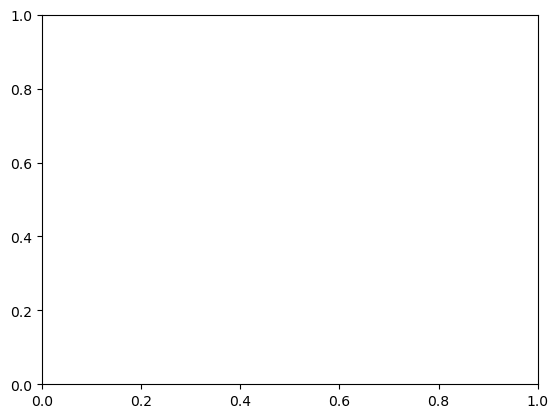

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
for fid in geodataframe.NUTS_ID[:5]:
    reduced_data.sel(FID=fid).plot(ax=ax, label=fid)
    fig.legend()


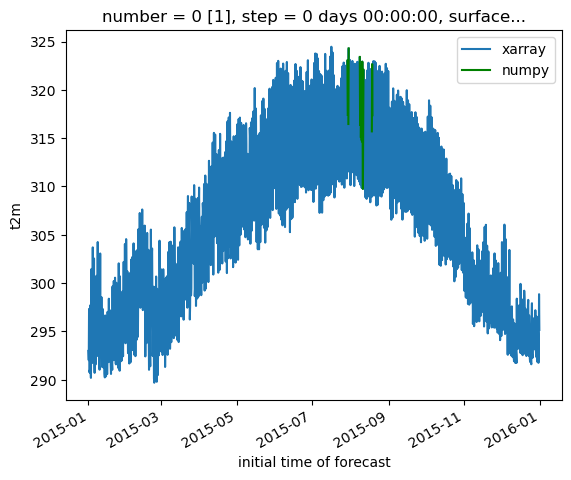

In [ ]:
mdataarray = dataarray.where(dataarray>273, other=np.nan)
# mdataarray.assign_attrs({'_FillValue': np.nan})
fig, ax = plt.subplots(1,1)
mdataarray.max(dim=['latitude','longitude']).plot(ax=ax, label='xarray')
ax.plot(
    mdataarray.time.values,
    np.max(mdataarray.values.reshape(1460,-1), axis=1),
    label='numpy', color='green'
)
plt.legend()

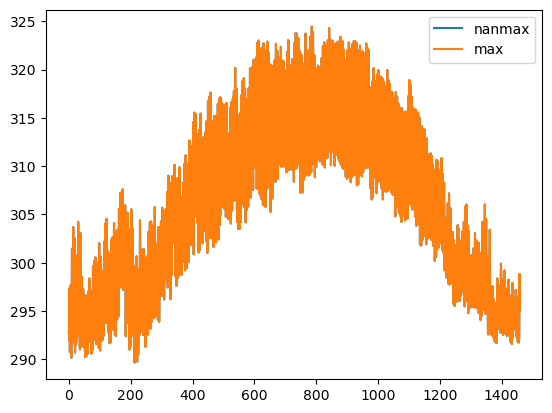

In [ ]:
mdataarray = dataarray.where(dataarray>273, other=np.nan)
mdataarray = mdataarray.to_masked_array()
fig, ax = plt.subplots(1,1)
ax.plot(np.nanmax(mdataarray.reshape(1460,-1), axis=1), label='nanmax')
ax.plot(np.max(mdataarray.reshape(1460,-1), axis=1), label='max')
plt.legend()